<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_14_clustering.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
# run this first
!pip install pyclustering

# BYU CS 473 — Comparing HAC, K-Means, and K-Medoids  

In this assignment, you will learn the similarities and differences between **Hierarchical Agglomerative Clustering (HAC)** with different linkage strategies and **partitioning methods** such as k-means and k-medoids.  

We will emphasize the tradeoffs between linkage strategies in HAC and why **k-medoids** can sometimes be more robust than k-means.  

---

## Learning Goals
- Understand how **HAC** works with different linkage methods:  
  - Single Link (nearest-neighbor / minimum distance)  
  - Complete Link (furthest-neighbor / maximum distance)  
  - Average Link (mean distance)  
- Compare **HAC** with **k-means** clustering.  
- Understand why **k-medoids** is a robust alternative to k-means.  
- Visualize clustering results to see strengths and weaknesses.  

## Part 1 — Hierarchical Agglomerative Clustering (HAC)  

Hierarchical Agglomerative Clustering starts with each data point in its own cluster and **merges clusters step by step** until only one cluster remains.  

The choice of **linkage** determines how distances between clusters are measured:  
- **Single Link**: distance between the two *closest* points (can cause "chaining")  
- **Complete Link**: distance between the two *furthest* points (tends to form compact clusters)  
- **Average Link**: average distance between all points across clusters (balances chaining and compactness)  

### Task:
1. Generate a synthetic 2D dataset (e.g., blobs or moons).  
2. Apply HAC with each linkage method.  
3. Visualize dendrograms and final clusters.  


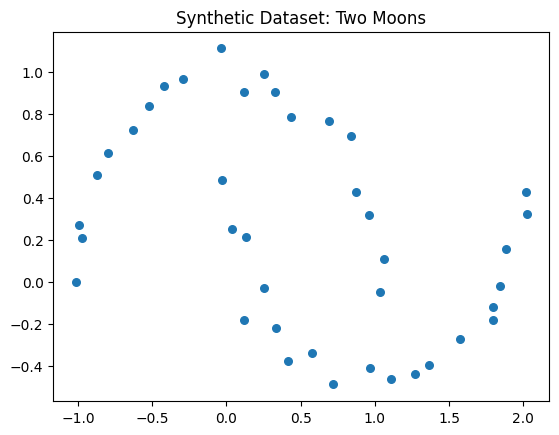

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Create synthetic dataset
X, y_true = make_moons(n_samples=40, noise=0.05, random_state=42)

# Plot dataset
plt.scatter(X[:,0], X[:,1], s=30)
plt.title("Synthetic Dataset: Two Moons")
plt.show()


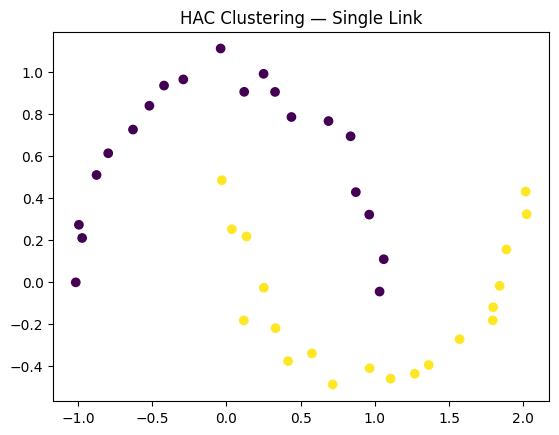

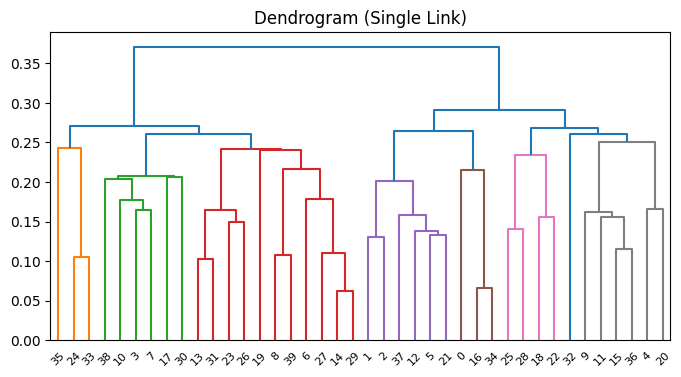

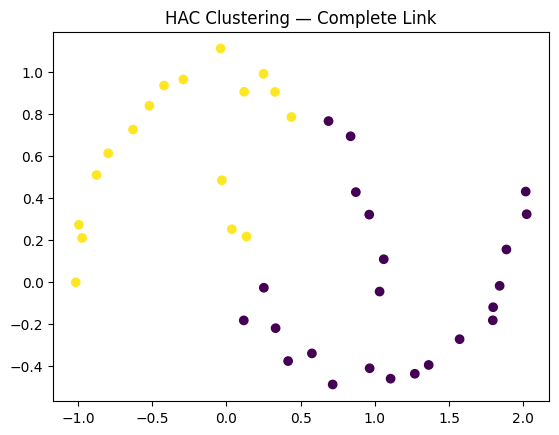

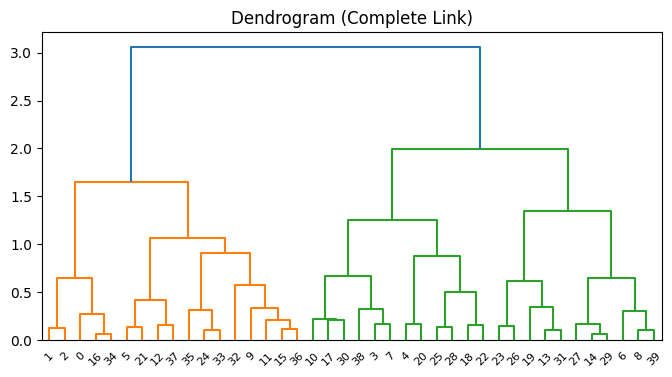

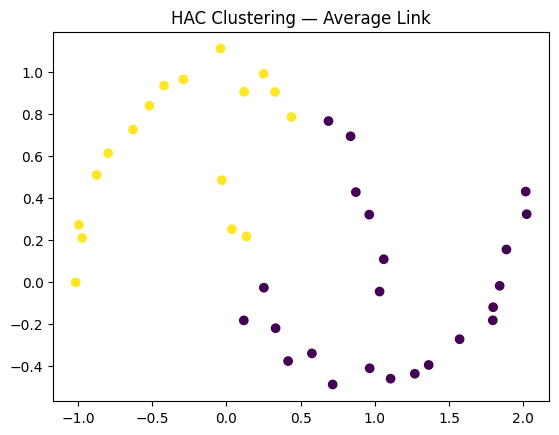

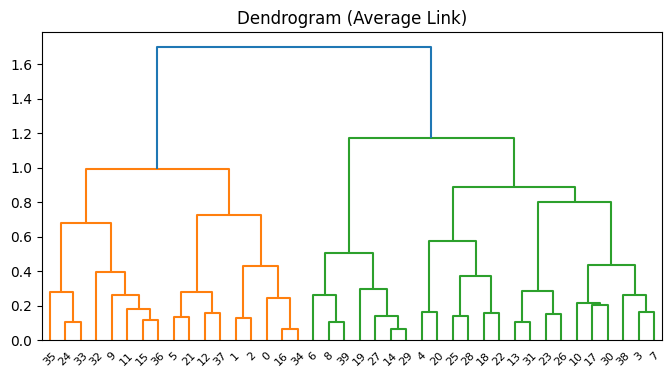

In [3]:
# HAC with different linkages
for method in ['single','complete','average']:
    hac = AgglomerativeClustering(n_clusters=2, linkage=method)
    labels = hac.fit_predict(X)

    plt.scatter(X[:,0], X[:,1], c=labels, cmap="viridis")
    plt.title(f"HAC Clustering — {method.title()} Link")
    plt.show()

    print()

    plt.figure(figsize=(8,4))
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title(f"Dendrogram ({method.title()} Link)")
    plt.show()

    print("\n")


## Part 2 — K-Means Clustering  

K-means clustering partitions data into **k clusters** by:  
1. Randomly initializing k centroids  
2. Assigning each point to the nearest centroid  
3. Updating centroids as the **mean** of assigned points  
4. Repeating until convergence  

### Task:
1. Apply k-means to the same dataset.  
2. Compare results to HAC.  

**Question:** What happens to k-means on non-spherical data (like moons)?  


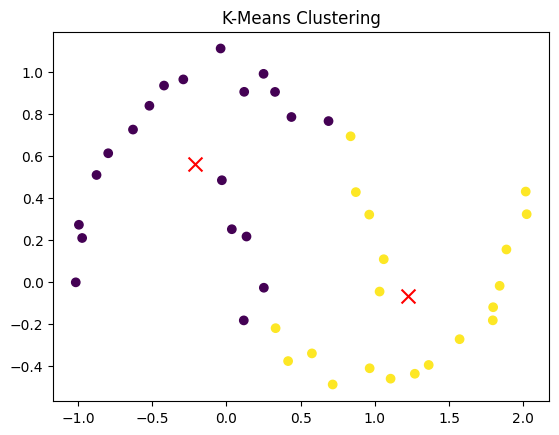

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=labels_kmeans, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            c="red", marker="x", s=100)
plt.title("K-Means Clustering")
plt.show()


K-means seems to have output a similar result to Average Link and Complete Link HAC. Only Single Link HAC seems to have split the data correctly.

K-means assumes that clusters are convex and roughly circular. When the classes overlap or wrap around each other, it doesn't quite work.

## Part 3 — K-Medoids (Partitioning Around Medoids, PAM) on Moon Dataset

K-medoids is similar to k-means, **but instead of using the mean**, it chooses actual **data points (medoids)** as cluster centers.  

This makes k-medoids more **robust to outliers** and suitable for arbitrary distance metrics (not just Euclidean).  

### Task:
1. Apply k-medoids (PAM algorithm) to the dataset.  
2. Compare results to k-means.  


Cluster assignments: [[0, 1, 2, 5, 9, 10, 11, 12, 15, 16, 17, 21, 24, 30, 32, 33, 34, 35, 36, 37], [3, 4, 6, 7, 8, 13, 14, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 31, 38, 39]]
Medoid indices: [35, 22]


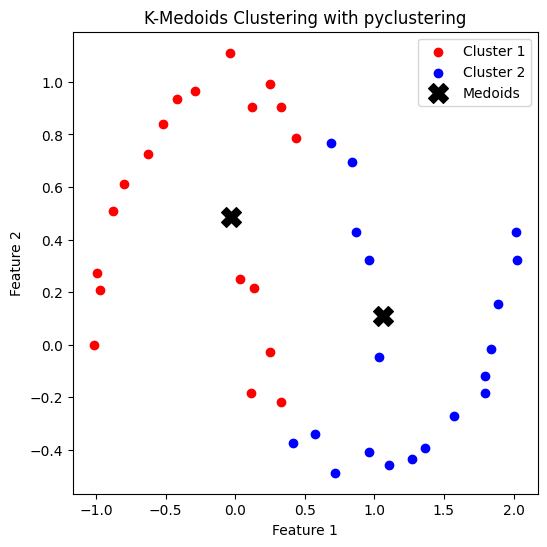

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix



# Choose initial medoids (indices of points in X)
initial_medoids = [0, 25]

# Run K-Medoids
kmedoids_instance = kmedoids(X.tolist(), initial_medoids, data_type='points')
kmedoids_instance.process()

clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

print("Cluster assignments:", clusters)
print("Medoid indices:", medoids)

# --- Visualization ---
colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 6))
for cluster_idx, cluster in enumerate(clusters):
    points = np.array([X[i] for i in cluster])
    plt.scatter(points[:, 0], points[:, 1],
                c=colors[cluster_idx % len(colors)],
                label=f"Cluster {cluster_idx+1}")

# Plot medoids
medoid_points = np.array([X[i] for i in medoids])
plt.scatter(medoid_points[:, 0], medoid_points[:, 1],
            c='black', marker='X', s=200, label="Medoids")

plt.title("K-Medoids Clustering with pyclustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


The medoids' centers are a little off from k-mean's centroids, and that results in a few points swapping sides, but it's overall very similar.

## Part 4 — Reflection  

1. Which HAC linkage method worked best for the moons dataset? Why?  
2. How does the dendrogram help us decide the number of clusters?  
3. What was the main weakness of k-means in this example?  
4. Why is k-medoids more robust than k-means?  
5. In practice, when would you prefer HAC vs. k-means vs. k-medoids?  


1. Which HAC linkage method worked best for the moons dataset? Why?

    Single Link HAC was the only method that correctly split the data. Single Link computes the distance between two clusters as the minimum distance between any pair of points in the clusters, allowing it to find the twisting gap between the datasets.

2. How does the dendrogram help us decide the number of clusters?

    Looking at the dedrogram shows the distances at which clusters combine. You can use that information to determine what makes the most sense.

3. What was the main weakness of k-means in this example?

    K-means assumes that clusters are convex and roughly circular. When the classes overlap or wrap around each other, it doesn't quite work.

4. Why is k-medoids more robust than k-means?

    Because k-medoids uses actual data points as cluster centers, it is more robust to outliers and suitable for arbitrary distance metrics (not just Euclidean).

5. In practice, when would you prefer HAC vs. k-means vs. k-medoids?

    HAC is best when K is unknown, or there are nested or irregular shapes. K-Means is best for large datasets with spherical clusters and known k. K-Medoids is best for handling outliers, arbitrary distances, and interpretable data.